In [1]:
import os
import pickle

import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='sans-serif')

from tqdm.autonotebook import tqdm

import torch.distributions as dist
import zuko

from geobed import BED_discrete
from geobed.fwd_collection.avo import *

/tmp/ipykernel_44476/2356803356.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# model prior
a_1_model = torch.tensor(2750.0)
d_model   = torch.tensor(500.0 )

a_2_mean = torch.tensor([3750.0])
a_2_std = torch.tensor([300.0])
a_2_prior_dist = dist.Independent(dist.Normal(a_2_mean, a_2_std), 1)

# a_2_min = torch.tensor([3000.0])
# a_2_max = torch.tensor([4500.0])
# a_2_prior_dist = dist.Independent(dist.Uniform(a_2_min, a_2_max), 1)

In [3]:
class MDN_guide(torch.nn.Module):
    def __init__(self, data_features, model_features, design_features=0, **kwargs):

        self.data_mean = torch.ones(data_features)*0.5
        self.data_std  = torch.ones(data_features)*0.5
        
        initial_design = torch.linspace(0.0, 3500.0, 10)
        
        self.design_mean = torch.ones(data_features)*initial_design.mean()
        self.design_std  = torch.ones(data_features)*initial_design.std()
        
        model_mean = torch.tensor([3750.0])
        model_std  = torch.tensor([750.0])
    
        super().__init__()
    
        self.base = zuko.flows.GMM(features=model_features, context=data_features+design_features, **kwargs)
        
        initial_means = a_2_prior_dist.sample((kwargs['components'],))
        
        min_index = self.base.sizes[0]
        max_index = self.base.sizes[0] + self.base.sizes[1]
        self.base.hyper[-1].bias.data[min_index:max_index]  = ((initial_means-model_mean)/model_std).flatten().detach()
        
        self.transforms = [zuko.flows.Unconditional(dist.AffineTransform, -model_mean/model_std, 1/model_std, buffer=True),]# buffer=True excludes the parameters from the optimization
    
    def forward(self, d, design=None):
        
        d = ((d-self.data_mean)/self.data_std)
        
        if design is not None:
            design = ((design-self.design_mean)/self.design_std)
            d = torch.cat([d, design.repeat(d.shape[0],1)], dim=-1)

        transform = zuko.transforms.ComposedTransform(*(t(d) for t in self.transforms))

        if d is None:
            base = self.base(d)
        else:
            base = self.base(d).expand(d.shape[:-1])

        return zuko.flows.NormalizingFlow(transform, base)
        
    def log_prob(self, m, d, design=None):
        
        out = self.forward(d, design).log_prob(m)
                
        return out
    
    def sample(self, d, n_samples, design=None):
        
        shape = torch.Size([n_samples])
        return self.forward(d, design).sample(shape).squeeze(0)

In [4]:
def data_likelihood(d, **kwargs):
    std_data = 0.05
    return dist.Independent(dist.Normal(d, torch.tensor(std_data)), 1)

def forward_function(offset, a_2):
    fwd_samples = calculate_avo(offset, a_1_model, a_2, d_model)
    # use rsample to sample with reparametrization trick to get gradients
    return data_likelihood(fwd_samples).rsample()

In [5]:
def sgd_design_optimisation(
    initial_design,
    fwd_function,
    n_steps,
    n_batch,
    guide,
    design_optimizer=None,
    guide_optimizer=None,
    design_scheduler=None,
    guide_scheduler=None,
    design_optimizer_args={},
    guide_optimizer_args={},
    design_scheduler_args={},
    guide_scheduler_args={},
    pass_design_to_guide=False,
    disable_tqdm=False,
    ):

    is_nan = False
    
    initial_design = initial_design.clone().detach().requires_grad_(True)
        
    losses = []
    design_history = []
    
    if design_optimizer is None:
        design_optimizer = torch.optim.Adam
    if guide_optimizer is None:
        guide_optimizer = torch.optim.Adam
    
    d_optim = design_optimizer([{'params': initial_design,}],
                               **design_optimizer_args)
    g_optim = guide_optimizer(guide.parameters(),
                              **guide_optimizer_args)
    
    class dummy_scheduler:
        def step(self):
            pass
    
    d_sched = design_scheduler(d_optim, **design_scheduler_args) if design_scheduler is not None else dummy_scheduler()
    g_sched = guide_scheduler(g_optim, **guide_scheduler_args) if guide_scheduler is not None else dummy_scheduler()
    

    for step in (pbar := tqdm(range(n_steps), desc='Loss: 0.000', miniters=int(n_steps/1000), position=1, disable=disable_tqdm)):
    
        model_batch = a_2_prior_dist.sample((n_batch,))
        
        data_batch = fwd_function(initial_design, model_batch)
                        
        d_optim.zero_grad()
        g_optim.zero_grad()
        
        if not pass_design_to_guide:
            loss = -guide.log_prob(model_batch, data_batch).mean()
        else:            
            loss = -guide.log_prob(model_batch, data_batch, initial_design).mean()
            
        loss.backward()
        
        initial_design.grad.data = torch.nan_to_num(initial_design.grad.data, (torch.randn(1)*1e-6).item())

        d_optim.step()
        g_optim.step()
                
        d_sched.step()
        g_sched.step()

        with torch.no_grad():
             initial_design.clamp_(min=-3500.0, max=3500.0)
        
        losses.append(loss.item())
        design_history.append(abs(initial_design.detach().numpy()).copy())
        
        if step % 100 == 0:
            pbar.set_description(f"Loss: {loss.detach().item():.3f}")
            pbar.update(1)
    
    return losses, design_history

In [6]:
n_steps = 400000
n_batch = 1

# guide = MDN_guide(data_features=10, model_features=1, components=20, hidden_features=[80, 80, 80], normalize=True)
guide = MDN_guide(data_features=10, model_features=1, design_features=10, components=20, hidden_features=[100, 100, 100], normalize=True)

d_optim = torch.optim.Adam
d_optim_args = {'lr': 3.5}
d_scheduler = torch.optim.lr_scheduler.StepLR
d_scheduler_args = {'step_size': int(n_steps/3), 'gamma': 0.3}

g_optim = torch.optim.Adam
g_optim_args = {'lr': 0.001}
g_scheduler = torch.optim.lr_scheduler.StepLR
g_scheduler_args = {'step_size': int(n_steps/3), 'gamma': 0.3}

In [7]:
initial_design = torch.linspace(50.0, 3450.0, 10)

filename = 'data/avo_onestep_10rec.pkl'

if os.path.exists(filename):
    print(f'Loading eig values from {filename}')
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    losses = np.array(results[0])
    design_history = np.array(results[1])

else:
    print(f'File {filename} does not exist. Calculating eig values.')
    results = sgd_design_optimisation(
        initial_design=initial_design,
        fwd_function=forward_function,
        n_steps=n_steps,
        n_batch=n_batch,
        guide=guide,
        design_optimizer=d_optim, 
        guide_optimizer=g_optim,
        design_scheduler=d_scheduler,
        guide_scheduler=g_scheduler,
        design_optimizer_args=d_optim_args,
        guide_optimizer_args=g_optim_args,
        design_scheduler_args=d_scheduler_args,
        guide_scheduler_args=g_scheduler_args,
        pass_design_to_guide=True,
    )

    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    losses = np.array(results[0])
    design_history = np.array(results[1])

del results

Loading eig values from data/avo_onestep_10rec.pkl


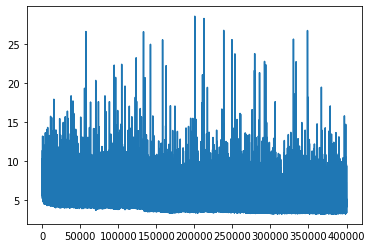

In [8]:
plt.plot(losses)
plt.show()

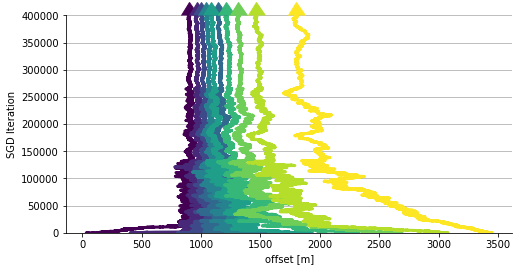

In [9]:
from cycler import cycler

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

color = plt.cm.viridis(np.linspace(0, 1, 10))
custom_cycler = (cycler(color=color))
ax.set_prop_cycle(custom_cycler)

ax.plot(design_history[::4], list(range(len(design_history)))[::4], alpha=1.0, linewidth=3.0)

for i in range(10):
    ax.plot([design_history[-1][i],], [len(design_history)*np.ones_like(design_history[-1][i]),],
            marker=10, markersize=17, linestyle='None',
            label='Final design', clip_on=False)

ax.set_ylim(0, len(design_history))

ax.set_ylabel('SGD Iteration')
ax.set_xlabel('offset [m]')

ax.yaxis.grid(True, alpha=0.8, linestyle='-', linewidth=1.0)


for spine in ['top', 'right',]:
    ax.spines[spine].set_visible(False)    

fig.savefig('figures/avo_onestep_10rec_designs_design_history.pdf', bbox_inches='tight',
            dpi=120, transparent=True)
fig.savefig('figures/avo_onestep_10rec_designs_design_history.png', bbox_inches='tight',
            dpi=120, transparent=True)
plt.show()


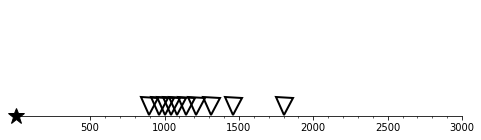

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

for i in range(10):
    ax.plot([design_history[-1][i],], [np.ones_like(design_history[-1][i]),],
            marker='v', markersize=17, linestyle='None', clip_on=False, color='k', fillstyle='none', markeredgewidth=2.0)

ax.plot([0,], [0.9,], marker='*', clip_on=False, markersize=17, color='k', linestyle='None')

ax.set_xlim(0, 3000)
ax.set_xticks([500, 1000, 1500, 2000, 2500, 3000])
ax.set_xticks(np.linspace(500, 3000, 26), minor=True)

ax.set_ylim(0.9, 2)
ax.set_yticks([])

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
    
plt.show()

# Starting with Heuristic

In [11]:
heuristic_n_steps = 200000
heuristic_n_batch = 1

# guide = MDN_guide(data_features=10, model_features=1, components=20, hidden_features=[64, 64, 64], normalize=True)
heuristic_guide = MDN_guide(data_features=10, model_features=1, design_features=10, components=20, hidden_features=[100, 100, 100], normalize=True)

heuristic_d_optim = torch.optim.Adam
heuristic_d_optim_args = {'lr': 3.5}
heuristic_d_scheduler = torch.optim.lr_scheduler.StepLR
heuristic_d_scheduler_args = {'step_size': int(heuristic_n_steps/1.5), 'gamma': 0.3}

heuristic_g_optim = torch.optim.Adam
heuristic_g_optim_args = {'lr': 0.001}
heuristic_g_scheduler = torch.optim.lr_scheduler.StepLR
heuristic_g_scheduler_args = {'step_size': int(heuristic_n_steps/1.5), 'gamma': 0.3}

In [12]:
initial_design_heuristic = torch.linspace(500.0, 1500.0, 10)

filename = 'data/avo_onestep_10rec_heuristic.pkl'

if os.path.exists(filename):
    print(f'Loading eig values from {filename}')
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    losses_heuristic = np.array(results[0])
    design_history_heuristic = np.array(results[1])

else:
    print(f'File {filename} does not exist. Calculating eig values.')
    results = sgd_design_optimisation(
        initial_design=initial_design_heuristic,
        fwd_function=forward_function,
        n_steps=heuristic_n_steps,
        n_batch=heuristic_n_batch,
        guide=heuristic_guide,
        design_optimizer=heuristic_d_optim,
        guide_optimizer=heuristic_g_optim,
        design_scheduler=heuristic_d_scheduler,
        guide_scheduler=heuristic_g_scheduler,
        design_optimizer_args=heuristic_d_optim_args,
        guide_optimizer_args=heuristic_g_optim_args,
        design_scheduler_args=heuristic_d_scheduler_args,
        guide_scheduler_args=heuristic_g_scheduler_args,
        pass_design_to_guide=True,
    )

    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    losses_heuristic = np.array(results[0])
    design_history_heuristic = np.array(results[1])
    
del results

Loading eig values from data/avo_onestep_10rec_heuristic.pkl


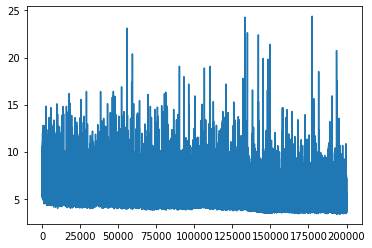

In [13]:
plt.plot(losses_heuristic)
plt.show()

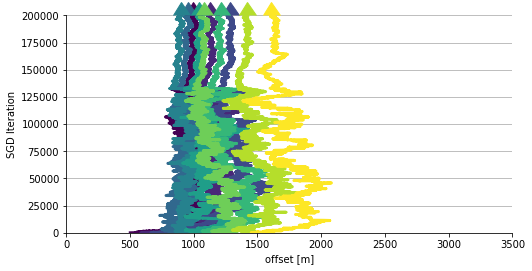

In [14]:
from cycler import cycler

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

color = plt.cm.viridis(np.linspace(0, 1, 10))
custom_cycler = (cycler(color=color))
ax.set_prop_cycle(custom_cycler)

ax.plot(design_history_heuristic, range(len(design_history_heuristic)), alpha=1.0, linewidth=3.0)

for i in range(10):
    ax.plot([design_history_heuristic[-1][i],], [len(design_history_heuristic)*np.ones_like(design_history_heuristic[-1][i]),],
            marker=10, markersize=17, linestyle='None',
            label='Final design', clip_on=False)

ax.set_ylim(0, len(design_history_heuristic))

ax.set_ylabel('SGD Iteration')
ax.set_xlabel('offset [m]')

ax.yaxis.grid(True, alpha=0.8, linestyle='-', linewidth=1.0)

ax.set_xlim(0, 3500)
# ax.set_xticks([500, 1000, 1500, 2000])


for spine in ['top', 'right',]:
    ax.spines[spine].set_visible(False)    

fig.savefig('figures/avo_onestep_10rec_heuristic_designs_design_history.pdf', bbox_inches='tight',
            dpi=120, transparent=True)
fig.savefig('figures/avo_onestep_10rec_heuristic_designs_design_history.png', bbox_inches='tight',
            dpi=120, transparent=True)
plt.show()


In [15]:
# def forward_function_discrete(offset, a_2):
#     fwd_samples = calculate_avo(offset, a_1_model, a_2, d_model)
#     return fwd_samples

# n_design_points = 200
# design_names = [str(i) for i in range(n_design_points)]
# offsets = np.linspace(100, 3500, n_design_points)

# torch.manual_seed(0)

# prior_samples = a_2_prior_dist.sample((int(1e9),))

# design_dicts = {}

# filename = 'data/avo_data_2000000_200.h5'

# for i, name in enumerate(design_names):
#     design_dicts[name] = {'index': i, 'offset': offsets[i], 'file': filename, 'dataset': 'data', 'cost': 1.0,}

# BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=prior_samples, prior_dist=a_2_prior_dist,
#                          design2data='lookup_1to1_design_flexible')


# iterative_benchmark, iterative_benchmark_info_dict = BED_class.find_optimal_design(
#     design_point_names=design_names,
#     design_budget=10,
#     eig_method='nmc',
#     eig_method_kwargs={'N':int(1e3), 'M':int(1e3), 'reuse_M_samples':False},
#     opt_method='iterative_construction',
#     opt_method_kwargs={},
#     num_workers=10,
#     filename='data/avo_gaussian_10rec_iterative_nmc_benchmark_eig.pkl',
#     parallel_method='joblib',
#     )

# iterative_benchmark_design = torch.tensor([design_dicts[d]['offset'] for d in iterative_benchmark]).float()
# print(iterative_benchmark_design)

In [16]:
def forward_function_discrete(offset, a_2):
    fwd_samples = calculate_avo(offset, a_1_model, a_2, d_model)
    return fwd_samples

n_design_points = 200
design_names = [str(i) for i in range(n_design_points)]
offsets = np.linspace(100, 3500, n_design_points)

torch.manual_seed(0)

prior_samples = a_2_prior_dist.sample((int(1e5),))

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'forward_function': forward_function_discrete, 'cost': 1.0,}

def constructor_1to1_design(self, name_list, n_samples):
        
    name_list = list(dict.fromkeys(name_list)) # remove duplicates 
    # list(set(name_list)) destroys the order of the list
    design_dicts_list = [self.design_dicts[n] for n in name_list]
    
    data = torch.zeros((n_samples, len(name_list), 2))

    for i, d_meta in enumerate(design_dicts_list):
        data[:, i, :] = d_meta['forward_function'](d_meta['offset'], self.prior_samples[:n_samples])

    return data.flatten(start_dim=-2)

BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=prior_samples, prior_dist=a_2_prior_dist,
                         design2data=constructor_1to1_design)


iterative_benchmark, iterative_benchmark_info_dict = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=10,
    eig_method='nmc',
    eig_method_kwargs={'N':int(1e4), 'M':int(1e4), 'reuse_M_samples':True, 'memory_efficient':True},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=10,
    filename='data/avo_gaussian_10rec_iterative_nmc_benchmark_eig.pkl',
    # parallel_method='joblib',
    )

iterative_benchmark_design = torch.tensor([design_dicts[d]['offset'] for d in iterative_benchmark]).float()
print(iterative_benchmark_design)

tensor([1039.6985,  937.1859, 1176.3820, 1090.9548, 1295.9799,  988.4422,
         885.9296, 1125.1256, 1398.4924, 1005.5276])


In [17]:
def constructor_1to1_design(self, name_list, n_samples):
        
    name_list = list(dict.fromkeys(name_list)) # remove duplicates 
    # list(set(name_list)) destroys the order of the list
    design_dicts_list = [self.design_dicts[n] for n in name_list]
    
    data = torch.zeros((n_samples, len(name_list), 10))

    for i, d_meta in enumerate(design_dicts_list):
        data[:, i, :] = d_meta['forward_function'](d_meta['offset'], self.prior_samples[:n_samples])

    return data.flatten(start_dim=-2)

In [18]:
optimal_design_sgd_equispaced = torch.from_numpy(design_history[-1]).float()
optimal_design_sgd_heuristic  = torch.from_numpy(design_history_heuristic[-1]).float()

optimal_design_heuristic = torch.linspace(500.0, 1500.0, 10).float()
optimal_design_guest     = torch.tensor([775.36, 800.72, 876.81, 927.53, 1050.72, 1152.1, 1250, 1326.0, 1525.36, 1601.44, ])

equispaced_benchmark_design = torch.linspace(100.0, 3500.0, 10).float()
# design_list = torch.stack([optimal_design_heuristic, optimal_design_sgd_equispaced, optimal_design_sgd_heuristic,
#                            optimal_design_guest])

design_list = torch.stack([optimal_design_heuristic, optimal_design_sgd_equispaced, optimal_design_sgd_heuristic,
                           optimal_design_guest, iterative_benchmark_design, equispaced_benchmark_design])

In [19]:
# optimal_design_heuristic, optimal_design_sgd_equispaced, optimal_design_sgd_heuristic, optimal_design_guest

design_names = [str(i) for i in range(len(design_list))]

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': design_list[i], 'forward_function': forward_function_discrete, 'cost': 1.0,}
    
n_trials = 5

filename = 'data/avo_gaussian_10rec_nmc_benchmark_eig.pkl'

if os.path.isfile(filename):
    print(f'File {filename} exists. Loading eig values.')
    eig_list = torch.load(filename)

else:
    print(f'File {filename} does not exist. Calculating eig values.')
    eig_list = []

    for seed in tqdm(range(n_trials)):

        torch.manual_seed(seed)

        n_samples = int(2e5)
        prior_samples = a_2_prior_dist.sample((n_samples,))

        BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=prior_samples, prior_dist=a_2_prior_dist,
                                        design2data=constructor_1to1_design)
        
        eig_benchmark, info_benchmark = BED_class.calculate_eig_list(
            [[d,] for d in design_names],
            'nmc',
            method_kwargs={'N':int(1e5), 'M':int(1e5), 'reuse_M_samples':True, 'memory_efficient':True},
            num_workers=len(design_names),
            progress_bar=False,
            random_seed=seed,
            parallel_method='joblib',
            # filename=filename,   
        )
        
        eig_list.append(eig_benchmark)

    eig_list = torch.stack(eig_list)
    
    torch.save(eig_list, filename)

File data/avo_gaussian_10rec_nmc_benchmark_eig.pkl exists. Loading eig values.


In [20]:
eig_mean = eig_list.mean(dim=0)
eig_std  = eig_list.std(dim=0)

torch.set_printoptions(precision=4)
print(eig_mean)
print(eig_std)
torch.set_printoptions(profile='default')

tensor([2.8191, 3.1919, 3.2097, 2.9535, 3.2379, 1.8692])
tensor([0.0035, 0.0032, 0.0023, 0.0027, 0.0023, 0.0028])


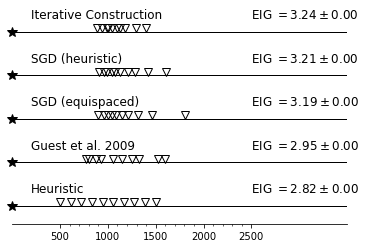

In [21]:
plt.rc('font', family='sans-serif')


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# design_list = torch.stack([optimal_design_heuristic, optimal_design_sgd_equispaced, optimal_design_sgd_heuristic,
                        #    optimal_design_guest, iterative_benchmark_design])
ordering = [1, 3, 4, 2, 5]

titles = ['Heuristic', 'SGD (equispaced)', 'SGD (heuristic)', 'Guest et al. 2009', 'Iterative Construction']

for i, design in enumerate(design_list[:-1]):

    off = ordering[i]

    ax.plot(design, off * np.ones_like(design),
            marker='v', markersize=8, linestyle='None', clip_on=False, color='k', fillstyle='none', markeredgewidth=1.0)
    ax.axhline(off-0.08, xmin=0, xmax=1, color='k', linestyle='-', linewidth=1.0)

    ax.plot([0,], [off-0.08,], marker='*', clip_on=False, markersize=10, color='k', linestyle='None')
    
    ax.text(200, off+0.3, titles[i], fontsize=12, ha='left', va='center')

    ax.text(2500, off+0.3, f'EIG $= {eig_mean[i]:.2f} \pm {eig_std[i]:.2f}$', fontsize=12, ha='left', va='center')


ax.set_xlim(0, 3500)
ax.set_xticks([500, 1000, 1500, 2000, 2500])
ax.set_xticks(np.linspace(500, 2500, 21), minor=True)

ax.set_ylim(0.5, 5.5)
ax.set_yticks([])

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.show()

In [22]:
result_dict = {
    'heu': {'eig': eig_mean[0], 'std': eig_std[0],
            'od': optimal_design_heuristic, 'title': 'Heuristic'},
    'eqi_sgd': {'eig': eig_mean[1], 'std': eig_std[1],
                'od': optimal_design_sgd_equispaced, 'd_hist': design_history,
                'title': 'SGD (equispaced)'},
    'heu_sgd': {'eig': eig_mean[2], 'std': eig_std[2],
                'od': optimal_design_sgd_heuristic, 'd_hist': design_history_heuristic,
                'title': 'SGD (heuristic)'},
    'guest': {'eig': eig_mean[3], 'std': eig_std[3],
              'od': optimal_design_guest,
              'title': 'Guest et al. 2009'},
    'iter': {'eig': eig_mean[4], 'std': eig_std[4],
             'od': iterative_benchmark_design,
             'title': 'Iterative Construction'
             },    
    'eqi': {'eig': eig_mean[5], 'std': eig_std[5],
            'od': equispaced_benchmark_design,
            'title': 'Equispaced'},
}

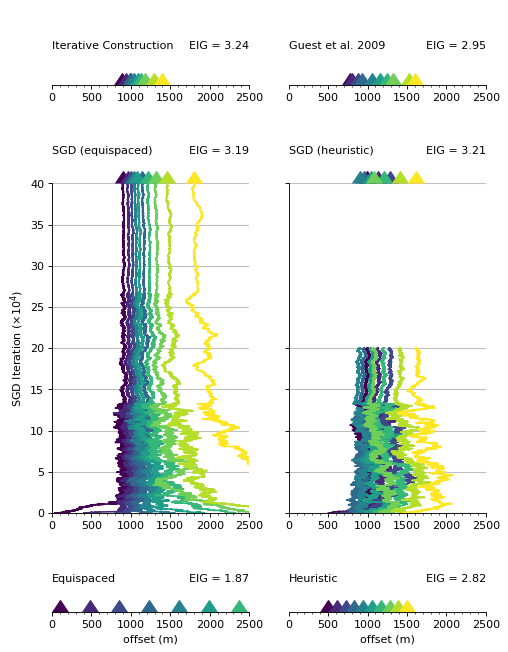

In [53]:
from matplotlib.ticker import FormatStrFormatter

fig, ax_dict = plt.subplot_mosaic(
    [
     ['iter'    , 'guest'],
     ['filler1', 'filler1'],
     ['eqi_sgd' , 'heu_sgd'],
     ['filler2', 'filler2'],
     ['eqi'     , 'heu'    ],
    ],
    # sharex=True,
    # sharey=True,
    figsize=(7, 10),
    gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [0.7, 0.9, 3, 0.3, 0.6],
                 'hspace': 0.0, }
)

ax_dict['filler1'].patch.set_alpha(0.0)
ax_dict['filler2'].patch.set_alpha(0.0)
ax_dict['filler1'].axis('off')
ax_dict['filler2'].axis('off')

for ax_name in ['eqi', 'heu', 'iter', 'guest']:
    
    ax = ax_dict[ax_name]
    od = result_dict[ax_name]['od']
    od = od.sort()[0]
    
    color = plt.cm.viridis(np.linspace(0, 1, 10))
    custom_cycler = (cycler(color=color))
    ax.set_prop_cycle(custom_cycler)
    
    for i in range(10):
        ax.plot([od[i],], [0,],
                marker=10, markersize=14, linestyle='None',
                # markeredgewidth=2,
                # mfc='none',
                clip_on=True)
    
    ax.set_xlim(0, 2500)
    ax.set_xticks([0, 500, 1000, 1500, 2000, 2500])
    ax.set_xticks(np.linspace(0, 2500, 26), minor=True)
    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([])

    if ax_name in ['eqi', 'heu']:
        ax.set_xlabel('offset (m)')

    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
        
    ax.text(0, 0.5,  result_dict[ax_name]['title'], fontsize=10, ha='left', va='center')

    ax.text(2500, 0.5, f'EIG = {result_dict[ax_name]["eig"]:.2f}', fontsize=10, ha='right', va='center')
    
for ax_name in ['heu_sgd', 'eqi_sgd']:
    
    ax = ax_dict[ax_name]
    od = result_dict[ax_name]['od']
    
    color = plt.cm.viridis(np.linspace(0, 1, 10))
    custom_cycler = (cycler(color=color))
    ax.set_prop_cycle(custom_cycler)
        
    if ax_name == 'heu_sgd':
        ax.plot(result_dict[ax_name]['d_hist'],
                np.array(range(len(result_dict[ax_name]['d_hist'])))/1e4, alpha=1.0, linewidth=1.5)
    else:    
        ax.plot(result_dict[ax_name]['d_hist'][::4],
                np.array(range(0, len(result_dict[ax_name]['d_hist']), 4))/1e4, alpha=1.0, linewidth=1.5)

    for i in range(10):
        ax.plot([result_dict[ax_name]['d_hist'][-1][i],],
                [len(result_dict['eqi_sgd']['d_hist'])/1e4*np.ones_like(result_dict[ax_name]['d_hist'][-1][i]),],
                marker=10, markersize=14,
                # markeredgewidth=2,
                # mfc='none',
                linestyle='None',
                label='Final design', clip_on=False)

    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.grid(True, alpha=0.8, linestyle='-', linewidth=1.0)
    # ax.yaxis.get_offset_text().set_visible(False)

    ax.set_xlim(0, 2500)
    ax.set_xticks([0, 500, 1000, 1500, 2000, 2500])
    ax.set_xticks(np.linspace(0, 2500, 26), minor=True)

    if ax_name == 'eqi_sgd':
        ax.set_yticks(np.arange(0, int(len(result_dict[ax_name]['d_hist'])/1e4+1), 50000/1e4))
        ax.set_ylabel(r'SGD Iteration ($\times 10^4$)')
    else:
        ax.set_yticks(np.arange(0, len(result_dict[ax_name]['d_hist'])/1e4+0.5, 50000/1e4).tolist() + [(len(result_dict['eqi_sgd']['d_hist'])/1e4),])
                
        ax.set_yticklabels([])

    ax.set_ylim(0, len(design_history)/1e4)

    ax.text(
        0,
        len(design_history)/1e4*1.10,
        result_dict[ax_name]['title'], fontsize=10, ha='left', va='center')

    ax.text(
        2500,
        len(design_history)/1e4*1.10,
        f'EIG = {result_dict[ax_name]["eig"]:.2f}',
        fontsize=10, ha='right', va='center')

    for spine in ['top', 'right',]:
        ax.spines[spine].set_visible(False)   
        
# ax_dict['eqi_sgd'].get_shared_y_axes().join(
#     ax_dict['eqi_sgd'], 
#     ax_dict['heu_sgd'])

fig.savefig('figures/avo_onestep_comparison.pdf', bbox_inches='tight',
            dpi=120, transparent=True)
fig.savefig('figures/avo_onestep_comparison.png', bbox_inches='tight',
            dpi=120, transparent=True)

plt.rcParams['figure.dpi'] = 80
plt.show()